In [1]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from skopt import BayesSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from skopt.space import Real, Integer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Connect to the database
conn = sqlite3.connect('../data/EPL_database.db')

# Example: list all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,Raw_LongTermForm_Season2023_2024_Season2023_2024
1,Raw_ShortTermForm_Season2023_2024_Season2023_2024
2,Raw_LongTermForm_Season2017_2018
3,Raw_LongTermForm_Season2018_2019
4,Raw_LongTermForm_Season2019_2020
5,Raw_LongTermForm_Season2020_2021
6,Raw_LongTermForm_Season2021_2022
7,Raw_LongTermForm_Season2022_2023
8,Raw_LongTermForm_Season2023_2024
9,DataCoUk_Season2017_2018


In [ ]:
# List of Databases we are going to use, which are all the matches between season 2017-18 to 2024-25
season_tables = [
    'DataCoUk_Season2017_2018',
    'DataCoUk_Season2018_2019',
    'DataCoUk_Season2019_2020',
    'DataCoUk_Season2020_2021',
    'DataCoUk_Season2021_2022',
    'DataCoUk_Season2022_2023',
    'DataCoUk_Season2023_2024',
    'DataCoUk_Season2024_2025'
]

# Merge all into a single DataFrame
db = pd.concat(
    [pd.read_sql_query(f"SELECT * FROM {table}", conn) for table in season_tables],
    ignore_index=True
)

# Optional: preview the result
db.head()


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA
3008,E0,04/05/2025,Brentford,Man United,4,3,H,2,1,H,...,1.70,4.46,4.61,1.68,4.50,5.30,1.56,2.76,2.11,1.88
3009,E0,04/05/2025,Brighton,Newcastle,1,1,D,1,0,H,...,3.35,3.80,2.13,3.30,3.90,2.24,1.60,2.62,2.02,1.97
3010,E0,04/05/2025,West Ham,Tottenham,1,1,D,1,1,D,...,1.90,3.98,3.92,1.91,4.10,4.20,1.64,2.54,1.91,2.08
3011,E0,04/05/2025,Chelsea,Liverpool,3,1,H,1,0,H,...,2.49,3.73,2.77,2.40,3.90,3.00,1.53,2.84,2.09,1.91
3012,E0,05/05/2025,Crystal Palace,Nott'm Forest,1,1,D,0,0,D,...,2.27,3.48,3.31,2.26,3.55,3.55,2.04,1.94,1.94,2.05


In [4]:
db.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690 entries, 0 to 2689
Columns: 153 entries, Div to BFECAHA
dtypes: float64(129), int64(16), object(8)
memory usage: 3.1+ MB


In [5]:
len(db)

2690

In [6]:
print(db.columns)


Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       '1XBCH', '1XBCD', '1XBCA', 'BFECH', 'BFECD', 'BFECA', 'BFEC>2.5',
       'BFEC<2.5', 'BFECAHH', 'BFECAHA'],
      dtype='object', length=153)


In [7]:
pd.set_option('display.max_columns', None)
print(db.columns.tolist())


['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA', 'Time', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2

We noticed that in some years the bookmakers are some, while on other years there are others. Furthermore, we don't really need all the different bookmakers predicting home winning, draw or away winning, so what we can do is create 3 single colums, indentical throughout all years, that are called odds_hw (odds home winning), odds_d (odds draw), odds_aw (odds away winning).

In [8]:
# Define groups of columns for home win, draw, and away win odds
home_win_cols = ['B365H', 'BWH', 'IWH', 'LBH', 'PSH', 'WHH', 'VCH', 'MaxH', 'AvgH', 'PSCH', 'B365CH', 'BWCH', 'IWCH', 'WHCH', 'VCCH', 'MaxCH', 'AvgCH', 'BFH', 'BFCH', '1XBH', '1XBCH']
draw_cols     = ['B365D', 'BWD', 'IWD', 'LBD', 'PSD', 'WHD', 'VCD', 'MaxD', 'AvgD', 'PSCD', 'B365CD', 'BWCD', 'IWCD', 'WHCD', 'VCCD', 'MaxCD', 'AvgCD', 'BFD', 'BFCD', '1XBD', '1XBCD']
away_win_cols = ['B365A', 'BWA', 'IWA', 'LBA', 'PSA', 'WHA', 'VCA', 'MaxA', 'AvgA', 'PSCA', 'B365CA', 'BWCA', 'IWCA', 'WHCA', 'VCCA', 'MaxCA', 'AvgCA', 'BFA', 'BFCA', '1XBA', '1XBCA']

# Compute row-wise means (ignoring NaNs)
db['odds_hw'] = db[home_win_cols].mean(axis=1)
db['odds_d']  = db[draw_cols].mean(axis=1)
db['odds_aw'] = db[away_win_cols].mean(axis=1)

# Drop the original odds columns
db.drop(columns=home_win_cols + draw_cols + away_win_cols, inplace=True)

In [9]:
# Checking if it worked
db[['HomeTeam', 'AwayTeam', 'odds_hw', 'odds_d', 'odds_aw']].head()

,HomeTeam,AwayTeam,odds_hw,odds_d,odds_aw
0,Arsenal,Leicester,1.50250,4.49750,6.60625
1,Brighton,Manchester City,10.33750,5.38125,1.32125
2,Chelsea,Burnley,1.25375,6.05000,13.93750
3,Crystal Palace,Huddersfield,1.81625,3.50500,4.90875
4,Everton,Stoke,1.71125,3.66500,5.49750


We are now going to plot some graphs to see interesting patterns....

Since we are going to keep the temporal order, we are dropping the 'Date' columns and also the 'Div' one because is irrelevant

In [10]:
dropping_columns = ['Div', 'Date']

db.drop(columns=dropping_columns, inplace=True)

We are going to do now the same with all ods that say over 2.5 and under 2.5

In [11]:
# Define columns for over and under 2.5 goals
over_cols = [
    'BbMx>2.5', 'BbAv>2.5', 'B365>2.5', 'P>2.5', 'Max>2.5', 'Avg>2.5',
    'B365C>2.5', 'PC>2.5', 'MaxC>2.5', 'AvgC>2.5', 'BFE>2.5', 'BFEC>2.5'
]

under_cols = [
    'BbMx<2.5', 'BbAv<2.5', 'B365<2.5', 'P<2.5', 'Max<2.5', 'Avg<2.5',
    'B365C<2.5', 'PC<2.5', 'MaxC<2.5', 'AvgC<2.5', 'BFE<2.5', 'BFEC<2.5'
]

# Create new averaged columns
db['odds_over2_5'] = db[over_cols].mean(axis=1)
db['odds_under2_5'] = db[under_cols].mean(axis=1)

db.drop(columns=over_cols + under_cols, inplace=True)


In [12]:
# Checking if it worked
db[['HomeTeam', 'AwayTeam', 'odds_over2_5', 'odds_under2_5']].head()

,HomeTeam,AwayTeam,odds_over2_5,odds_under2_5
0,Arsenal,Leicester,1.630,2.375
1,Brighton,Manchester City,1.665,2.335
2,Chelsea,Burnley,1.685,2.280
3,Crystal Palace,Huddersfield,2.150,1.755
4,Everton,Stoke,2.125,1.780


In [13]:
pd.set_option('display.max_columns', None)
print(db.columns.tolist())

['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'Time', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'BFEH', 'BFED', 'BFEA', 'BFEAHH', 'BFEAHA', 'BFECH', 'BFECD', 'BFECA', 'BFECAHH', 'BFECAHA', 'odds_hw', 'odds_d', 'odds_aw', 'odds_over2_5', 'odds_under2_5']


We decided now, after analyzing the whole dataset, to drop a lot of the existing columns because they show either:
- Max odds a bookmaker has for a certain game, which is irrelevant
- Minimum odds a bookmaker has for a certain game, which is also irrelevant
- Average of the odds, which we alredy have calcualted (we didn't know this column was there)
- Half time data: since we want to predict the output of a game before it starts, we can't have halftime data otherwise it will introduce leakage
- Exchange odds, which again we don't need

In [14]:
columns_to_drop = [
    'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA',
    'BbOU', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA',
    'AHh', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA',
    'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA',
    'BFEH', 'BFED', 'BFEA', 'BFECH', 'BFECD', 'BFECA', 'HTHG', 'HTAG', 'HTR', 'AHCh'
]

db.drop(columns=columns_to_drop, inplace=True)


And now we will merge and find the mean of all the asian odds for both home and away, as we did before

In [15]:
asian_home_cols = ['B365AHH', 'PAHH', 'B365CAHH', 'PCAHH', 'BFEAHH', 'BFECAHH']
db['odds_home_asian'] = db[asian_home_cols].mean(axis=1)

asian_away_cols = ['B365AHA', 'PAHA', 'B365CAHA', 'PCAHA', 'BFEAHA', 'BFECAHA']
db['odds_away_asian'] = db[asian_away_cols].mean(axis=1)

cols_to_drop_asian = [
    'B365AHH', 'PAHH', 'B365CAHH', 'PCAHH', 'BFEAHH', 'BFECAHH',
    'B365AHA', 'PAHA', 'B365CAHA', 'PCAHA', 'BFEAHA', 'BFECAHA'
]

db.drop(columns=cols_to_drop_asian, inplace=True)



In [16]:
# Checking if it worked
db[['HomeTeam', 'AwayTeam', 'odds_home_asian', 'odds_away_asian']].head()

,HomeTeam,AwayTeam,odds_home_asian,odds_away_asian
0,Arsenal,Leicester,NaN,NaN
1,Brighton,Manchester City,NaN,NaN
2,Chelsea,Burnley,NaN,NaN
3,Crystal Palace,Huddersfield,NaN,NaN
4,Everton,Stoke,NaN,NaN


In [17]:
# Checking if it worked
db[['HomeTeam', 'AwayTeam', 'odds_home_asian', 'odds_away_asian']].tail()

,HomeTeam,AwayTeam,odds_home_asian,odds_away_asian
2685,Nottingham Forest,Wolverhampton Wanderers,2.036667,1.905000
2686,West Ham,Manchester City,1.936667,1.991667
2687,Chelsea,Crystal Palace,1.950000,1.985000
2688,Newcastle United,Tottenham,1.928333,2.008333
2689,Manchester United,Liverpool,2.005000,1.933333


We can conclude that not all the data has asian odds, but that is not a problem

Let's look at the new dataset now:

In [18]:
db.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian
0,Arsenal,Leicester,4,3,H,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,NaN,1.50250,4.49750,6.60625,1.630,2.375,NaN,NaN
1,Brighton,Manchester City,0,2,A,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,NaN,10.33750,5.38125,1.32125,1.665,2.335,NaN,NaN
2,Chelsea,Burnley,2,3,A,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,NaN,1.25375,6.05000,13.93750,1.685,2.280,NaN,NaN
3,Crystal Palace,Huddersfield,0,3,A,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,NaN,1.81625,3.50500,4.90875,2.150,1.755,NaN,NaN
4,Everton,Stoke,1,0,H,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,NaN,1.71125,3.66500,5.49750,2.125,1.780,NaN,NaN


Way more clean and understandable, now we can proceede with plotting the graphs and see how our database reacts

To better understand what we have now, the columns with odd names are:
- FTHG and FTAG (our target variables): Full Time Home Goals and Full Time Away Goals
- FTR: Full Time Result
- HS and AS: Home Shots and Away Shots
- HST and AST: Home Shots on Target and Away Shots on Target
- HF and AF: Home Fouls and Away Fouls
- HC and AC: Home Corners and Away Corners
- HY and AY: Home Yellows (cards) and Away Yellows
- HR and AR: Home Reds (cards) and Away Reds

However, after further thought, we came with the understanding that features such as Shots, Shots on target, Fouls commited, Cards... That is, every in-game stat, cannot be used since we are trying to predict the result of a match before that match starts, so in a real world scenario we wouldn't have those information.  
However this doesn't mean that we have to drop those columns and that's it. We can still extract some valuable information from those columns, such as:  
- 'avg_goals_L5_home' and 'avg_goals_L10_away': The average goals scored by the home team in their last 10 home matches and the average goals scored by the away team in their last 10 away matches
- 'avg_shots_home_L5' and 'avg_shots_away_L10': The average shots by the home team in their last 10 home matches and the average shots by the away team in their last 10 away matches
- 'avg_shots_ont_home_L5' and 'avg_shots_ont_away_L10': The average shots on target by the home team in their last 10 home matches and the average shots on target by the away team in their last away 10 matches
- 'avg_corners_home_L5' and 'avg_corners_away_L10': The average corners taken by the home team in their last 10 home matches and the average corners taken by the away team in their last 10 away matches
- 'avg_goals_conceded_home_L5' and 'avg_goals_conceded_away_L10': Average goals conceeded by the home team in their last 10 home matches and average goals conceeded by the away team in their last 10 away matches
- 'avg_fouls_committed_home_L5' and 'avg_fouls_committed_away_L10': Average fouls committed by the home team in their last 10 home matches and average fouls committed by the away team in their last 10 away matches
- 'win_rate_home_L10' and 'win_rate_away_L5': Percentage of wins by the home team in their last 10 home games and percentage of wins by the away team in their last 10 away games
- 'draw_rate_home_L10' and 'draw_rate_away_L5': Same as above but for draws
- 'loss_rate_home_L10' and 'loss_rate_away_L5': Same as above but for losses
- 'home_strength_diff': The difference in net goal strength between home and away teams over their last 10 matches, where net strength = average goals scored minus average goals conceded, meaning that if the value in negative, the away team is stronger, and if is positive, the home team is stronger
- 'offensive_index_home' and 'offensive_index_away': Weighted combination of goals scored, shots, and shots on target in the last 10 matches for home and away teams, measuring their attacking ability.
- 'defensive_solidity_home' and 'defensive_solidity_away': Weighted combination of goals conceded, fouls committed, and inverse of win rate in the last 10 matches for home and away teams, measuring their defensive weakness (higher value = worse defense).
- 'avg_home_yellow_L10' and 'avg_away_yellow_L10': The average number of yellow cards received by the home and away teams respectively in their last 10 matches.
- 'avg_home_red_L10' and 'avg_away_red_L10': The average number of red cards received by the home and away teams respectively in their last 10 matches.
- 'h2h_avg_home_goals_last_5': The average number of goals the home team scored in its last 5 games against the current away team (home or away).
- 'h2h_avg_away_goals_last_5': The same but for the away team.

In [19]:
# Reset index to ensure consistent iteration
db.reset_index(drop=True, inplace=True)

# Initialize new columns
db['avg_goals_L5_home'] = None
db['avg_goals_L5_away'] = None

# Loop to calculate rolling averages
home_goals = []
away_goals = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Get last 10 home games for this home team before current match
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    avg_home_goals = past_home['FTHG'].tail(5).mean()
    home_goals.append(avg_home_goals)

    # Get last 10 away games for this away team before current match
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    avg_away_goals = past_away['FTAG'].tail(5).mean()
    away_goals.append(avg_away_goals)

# Assign computed values
db['avg_goals_L5_home'] = home_goals
db['avg_goals_L5_away'] = away_goals


In [20]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0


In [21]:
# Initialize new columns
db['avg_shots_home_L5'] = None
db['avg_shots_away_L5'] = None

# Loop to calculate rolling average shots
shots_home = []
shots_away = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Last 10 home games for home team
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    avg_home_shots = past_home['HS'].tail(5).mean()
    shots_home.append(avg_home_shots)

    # Last 10 away games for away team
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    avg_away_shots = past_away['AS'].tail(5).mean()
    shots_away.append(avg_away_shots)

# Assign values
db['avg_shots_home_L5'] = shots_home
db['avg_shots_away_L5'] = shots_away


In [22]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4


In [23]:
# Initialize new columns
db['avg_shots_ont_home_L5'] = None
db['avg_shots_ont_away_L5'] = None

# Loop to calculate rolling average shots on target
shots_ont_home = []
shots_ont_away = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Last 10 home games for home team
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    avg_home_shots_ont = past_home['HST'].tail(5).mean()
    shots_ont_home.append(avg_home_shots_ont)

    # Last 10 away games for away team
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    avg_away_shots_ont = past_away['AST'].tail(5).mean()
    shots_ont_away.append(avg_away_shots_ont)

# Assign values
db['avg_shots_ont_home_L5'] = shots_ont_home
db['avg_shots_ont_away_L5'] = shots_ont_away


In [24]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8


In [25]:
# Initialize new columns
db['avg_corners_home_L5'] = None
db['avg_corners_away_L5'] = None

# Loop to calculate rolling average corners
corners_home = []
corners_away = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Last 10 home games for home team
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    avg_home_corners = past_home['HC'].tail(5).mean()
    corners_home.append(avg_home_corners)

    # Last 10 away games for away team
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    avg_away_corners = past_away['AC'].tail(5).mean()
    corners_away.append(avg_away_corners)

# Assign values
db['avg_corners_home_L5'] = corners_home
db['avg_corners_away_L5'] = corners_away


In [26]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8


In [27]:
# Initialize new columns
db['avg_goals_conceded_home_L5'] = None
db['avg_goals_conceded_away_L5'] = None

# Loop to calculate rolling average goals conceded
gc_home = []
gc_away = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Last 10 home games of the home team
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    avg_gc_home = past_home['FTAG'].tail(5).mean()
    gc_home.append(avg_gc_home)

    # Last 10 away games of the away team
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    avg_gc_away = past_away['FTHG'].tail(5).mean()
    gc_away.append(avg_gc_away)

# Assign values
db['avg_goals_conceded_home_L5'] = gc_home
db['avg_goals_conceded_away_L5'] = gc_away


In [28]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6


In [29]:
# Initialize new columns
db['avg_fouls_committed_home_L5'] = None
db['avg_fouls_committed_away_L5'] = None

# Loop to calculate rolling average fouls committed
fouls_home = []
fouls_away = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Last 10 home games of home team
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    avg_fouls_home = past_home['HF'].tail(5).mean()
    fouls_home.append(avg_fouls_home)

    # Last 10 away games of away team
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    avg_fouls_away = past_away['AF'].tail(5).mean()
    fouls_away.append(avg_fouls_away)

# Assign values
db['avg_fouls_committed_home_L5'] = fouls_home
db['avg_fouls_committed_away_L5'] = fouls_away


In [30]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4


In [31]:
# Initialize new columns
db['win_rate_home_L5'] = None
db['win_rate_away_L5'] = None

# Loop to calculate win rates
win_rate_home = []
win_rate_away = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Last 10 home games of home team
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    recent_home = past_home.tail(5)
    home_wins = (recent_home['FTR'] == 'H').sum()
    win_rate_home.append(home_wins / len(recent_home) if len(recent_home) > 0 else None)

    # Last 10 away games of away team
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    recent_away = past_away.tail(5)
    away_wins = (recent_away['FTR'] == 'A').sum()
    win_rate_away.append(away_wins / len(recent_away) if len(recent_away) > 0 else None)

# Assign values
db['win_rate_home_L5'] = win_rate_home
db['win_rate_away_L5'] = win_rate_away


In [32]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4


In [33]:
# Initialize new columns
db['draw_rate_home_L5'] = None
db['draw_rate_away_L5'] = None

# Loop to calculate draw rates
draw_rate_home = []
draw_rate_away = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Last 10 home games of home team
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    recent_home = past_home.tail(5)
    home_draws = (recent_home['FTR'] == 'D').sum()
    draw_rate_home.append(home_draws / len(recent_home) if len(recent_home) > 0 else None)

    # Last 10 away games of away team
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    recent_away = past_away.tail(5)
    away_draws = (recent_away['FTR'] == 'D').sum()
    draw_rate_away.append(away_draws / len(recent_away) if len(recent_away) > 0 else None)

# Assign values
db['draw_rate_home_L5'] = draw_rate_home
db['draw_rate_away_L5'] = draw_rate_away


In [34]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4


In [35]:
# Initialize new columns
db['loss_rate_home_L5'] = None
db['loss_rate_away_L5'] = None

# Loop to calculate loss rates
loss_rate_home = []
loss_rate_away = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Last 10 home games of home team
    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    recent_home = past_home.tail(5)
    home_losses = (recent_home['FTR'] == 'A').sum()
    loss_rate_home.append(home_losses / len(recent_home) if len(recent_home) > 0 else None)

    # Last 10 away games of away team
    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    recent_away = past_away.tail(5)
    away_losses = (recent_away['FTR'] == 'H').sum()
    loss_rate_away.append(away_losses / len(recent_away) if len(recent_away) > 0 else None)

# Assign values
db['loss_rate_home_L5'] = loss_rate_home
db['loss_rate_away_L5'] = loss_rate_away


In [36]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2


In [37]:
# Create the feature 'home_strength_diff'
db['home_strength_diff'] = (
    (db['avg_goals_L5_home'] - db['avg_goals_conceded_home_L5']) -
    (db['avg_goals_L5_away'] - db['avg_goals_conceded_away_L5'])
)


In [38]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2


In [39]:
# Create the features 'offensive_index_home' and 'offensive_index_away'
db['offensive_index_home'] = (
    0.4 * db['avg_goals_L5_home'] +
    0.3 * db['avg_shots_home_L5'] +
    0.3 * db['avg_shots_ont_home_L5']
)

db['offensive_index_away'] = (
    0.4 * db['avg_goals_L5_away'] +
    0.3 * db['avg_shots_away_L5'] +
    0.3 * db['avg_shots_ont_away_L5']
)


In [40]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66


In [41]:
# Create the features 'defensive_solidity_home' and 'defensive_solidity_away'
db['defensive_solidity_home'] = (
    0.5 * db['avg_goals_conceded_home_L5'] +
    0.25 * db['avg_fouls_committed_home_L5'] +
    0.25 * (1 - db['win_rate_home_L5'])  # losing often hints at weaker defense
)

db['defensive_solidity_away'] = (
    0.5 * db['avg_goals_conceded_away_L5'] +
    0.25 * db['avg_fouls_committed_away_L5'] +
    0.25 * (1 - db['win_rate_away_L5'])
)


In [42]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14,4.15,4.65
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52,3.70,1.75
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80,2.65,3.95
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54,3.20,4.35
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66,3.05,4.30


In [43]:
# Create the features 'avg_home_yellow_L10' and 'avg_away_yellow_L10'
db['avg_home_yellow_L5'] = None
db['avg_away_yellow_L5'] = None

home_yellow = []
away_yellow = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    avg_home_yellow = past_home['HY'].tail(5).mean()
    home_yellow.append(avg_home_yellow)

    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    avg_away_yellow = past_away['AY'].tail(5).mean()
    away_yellow.append(avg_away_yellow)

db['avg_home_yellow_L5'] = home_yellow
db['avg_away_yellow_L5'] = away_yellow


In [44]:
# Create the features 'avg_home_red_L10' and 'avg_away_red_L10'
db['avg_home_red_L5'] = None
db['avg_away_red_L5'] = None

home_red = []
away_red = []

for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    past_home = db[(db.index < idx) & (db['HomeTeam'] == home_team)]
    avg_home_red = past_home['HR'].tail(5).mean()
    home_red.append(avg_home_red)

    past_away = db[(db.index < idx) & (db['AwayTeam'] == away_team)]
    avg_away_red = past_away['AR'].tail(5).mean()
    away_red.append(avg_away_red)

db['avg_home_red_L5'] = home_red
db['avg_away_red_L5'] = away_red


In [45]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away,avg_home_yellow_L5,avg_away_yellow_L5,avg_home_red_L5,avg_away_red_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,D,S Hooper,16,11,5,3,15,18,7,3,3,4,0,0,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14,4.15,4.65,1.0,2.4,0.0,0.2
2686,West Ham,Manchester City,1,3,A,M Oliver,10,23,2,8,10,3,3,11,3,2,0,0,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52,3.70,1.75,0.8,0.8,0.0,0.0
2687,Chelsea,Crystal Palace,1,1,D,J Gillett,13,9,7,3,9,13,4,5,4,2,0,0,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80,2.65,3.95,1.0,2.4,0.0,0.2
2688,Newcastle United,Tottenham,2,1,H,R Jones,9,20,3,6,16,13,7,12,4,4,0,0,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54,3.20,4.35,1.0,2.0,0.2,0.0
2689,Manchester United,Liverpool,0,3,A,A Taylor,8,11,3,3,7,7,5,2,4,1,0,0,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66,3.05,4.30,1.2,1.4,0.0,0.0


Now we can drop the in game statistic columns:

In [46]:
db.drop(columns=[
    'FTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR'
], inplace=True)


In [47]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,Referee,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away,avg_home_yellow_L5,avg_away_yellow_L5,avg_home_red_L5,avg_away_red_L5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,S Hooper,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14,4.15,4.65,1.0,2.4,0.0,0.2
2686,West Ham,Manchester City,1,3,M Oliver,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52,3.70,1.75,0.8,0.8,0.0,0.0
2687,Chelsea,Crystal Palace,1,1,J Gillett,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80,2.65,3.95,1.0,2.4,0.0,0.2
2688,Newcastle United,Tottenham,2,1,R Jones,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54,3.20,4.35,1.0,2.0,0.2,0.0
2689,Manchester United,Liverpool,0,3,A Taylor,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66,3.05,4.30,1.2,1.4,0.0,0.0


In [48]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690 entries, 0 to 2689
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HomeTeam                     2690 non-null   object 
 1   AwayTeam                     2690 non-null   object 
 2   FTHG                         2690 non-null   int64  
 3   FTAG                         2690 non-null   int64  
 4   Referee                      2690 non-null   object 
 5   Time                         1930 non-null   object 
 6   odds_hw                      2690 non-null   float64
 7   odds_d                       2690 non-null   float64
 8   odds_aw                      2690 non-null   float64
 9   odds_over2_5                 2690 non-null   float64
 10  odds_under2_5                2690 non-null   float64
 11  odds_home_asian              1930 non-null   float64
 12  odds_away_asian              1930 non-null   float64
 13  avg_goals_L5_home 

In [49]:
# Initialize new columns
db['h2h_avg_home_goals_last_5'] = None
db['h2h_avg_away_goals_last_5'] = None

# Loop through each match to compute head-to-head averages
for idx, row in db.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Get last 5 matches between these two teams (any order), before current match
    past_h2h = db[
        (db.index < idx) & (
            ((db['HomeTeam'] == home_team) & (db['AwayTeam'] == away_team)) |
            ((db['HomeTeam'] == away_team) & (db['AwayTeam'] == home_team))
        )
    ].tail(5)

    home_goals = []
    away_goals = []

    for _, match in past_h2h.iterrows():
        if match['HomeTeam'] == home_team:
            home_goals.append(match['FTHG'])
            away_goals.append(match['FTAG'])
        else:
            home_goals.append(match['FTAG'])
            away_goals.append(match['FTHG'])

    db.at[idx, 'h2h_avg_home_goals_last_5'] = sum(home_goals) / len(home_goals) if home_goals else None
    db.at[idx, 'h2h_avg_away_goals_last_5'] = sum(away_goals) / len(away_goals) if away_goals else None


In [50]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,Referee,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away,avg_home_yellow_L5,avg_away_yellow_L5,avg_home_red_L5,avg_away_red_L5,h2h_avg_home_goals_last_5,h2h_avg_away_goals_last_5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,S Hooper,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14,4.15,4.65,1.0,2.4,0.0,0.2,1.0,1.25
2686,West Ham,Manchester City,1,3,M Oliver,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52,3.70,1.75,0.8,0.8,0.0,0.0,0.8,2.6
2687,Chelsea,Crystal Palace,1,1,J Gillett,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80,2.65,3.95,1.0,2.4,0.0,0.2,1.8,0.6
2688,Newcastle United,Tottenham,2,1,R Jones,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54,3.20,4.35,1.0,2.0,0.2,0.0,2.8,2.2
2689,Manchester United,Liverpool,0,3,A Taylor,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66,3.05,4.30,1.2,1.4,0.0,0.0,0.8,2.8


# Plots

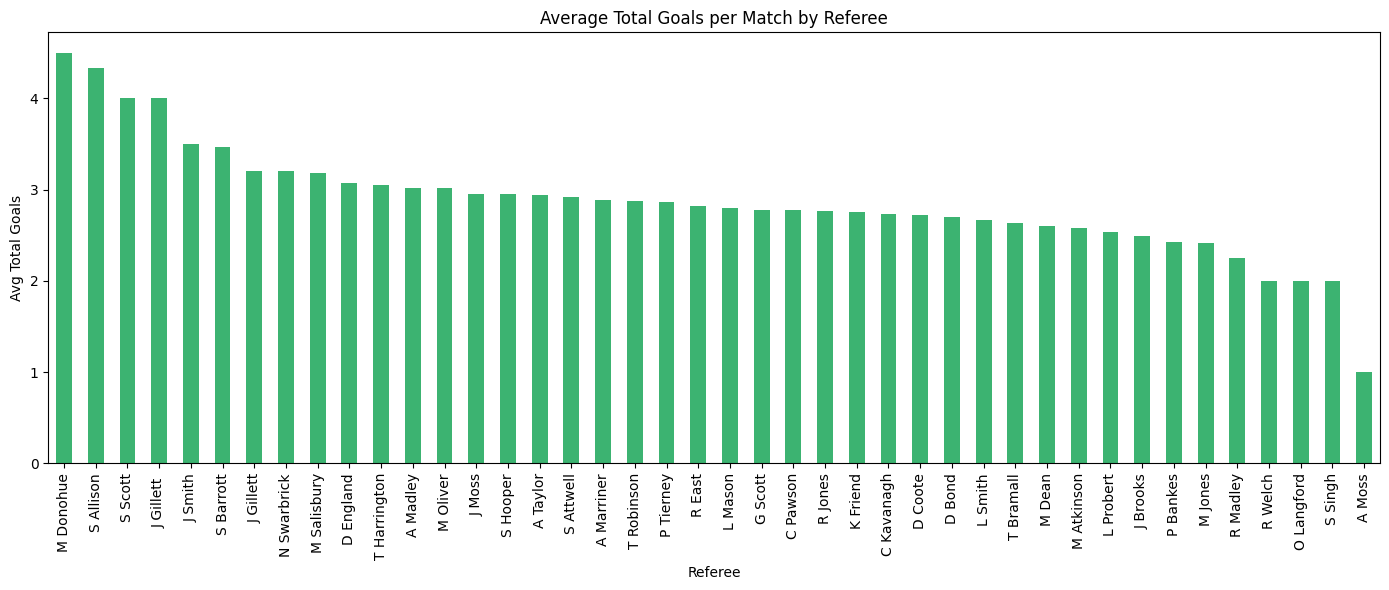

In [51]:

# Create total goals column
db['TotalGoals'] = db['FTHG'] + db['FTAG']

# Group by referee and compute average total goals
ref_avg_goals = db.groupby('Referee')['TotalGoals'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 6))
ref_avg_goals.plot(kind='bar', color='mediumseagreen')
plt.title('Average Total Goals per Match by Referee')
plt.ylabel('Avg Total Goals')
plt.xlabel('Referee')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

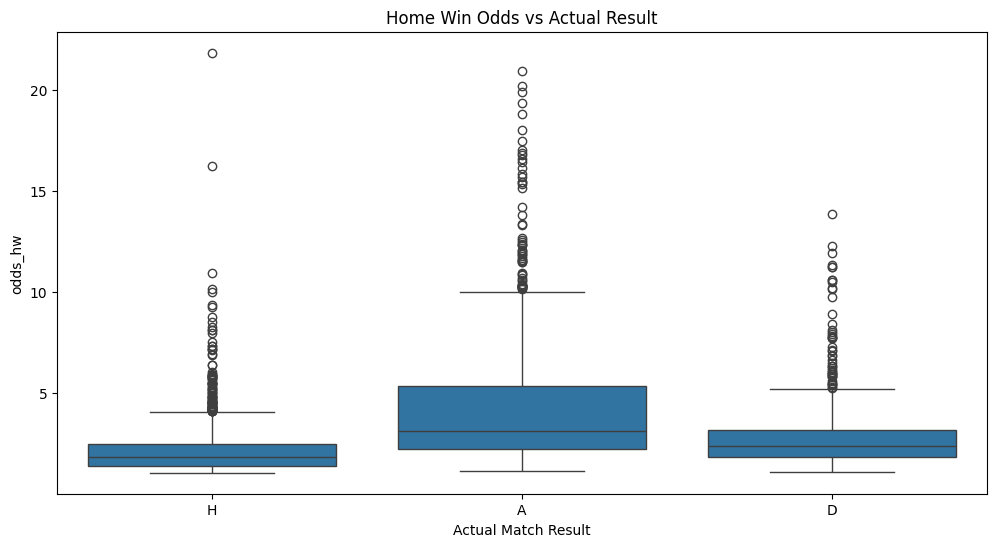

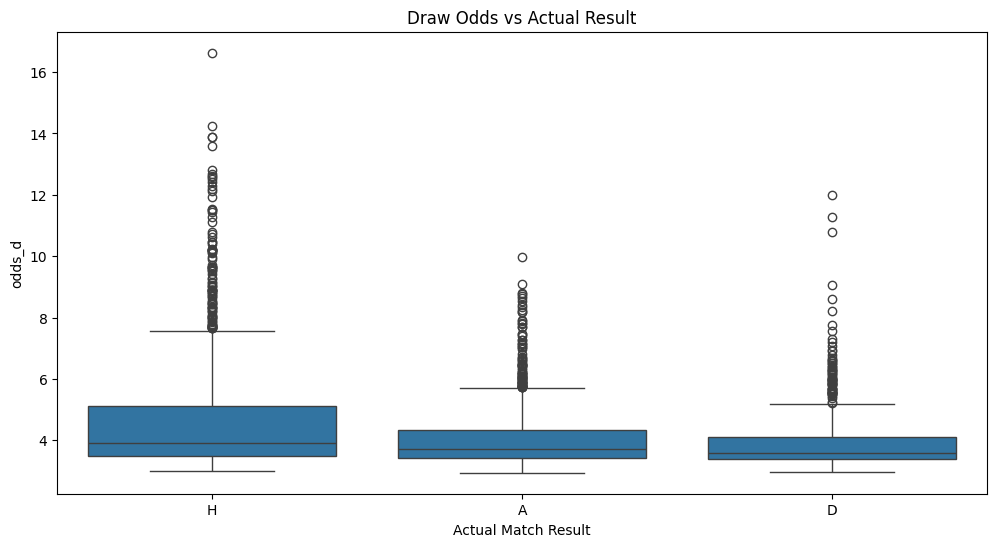

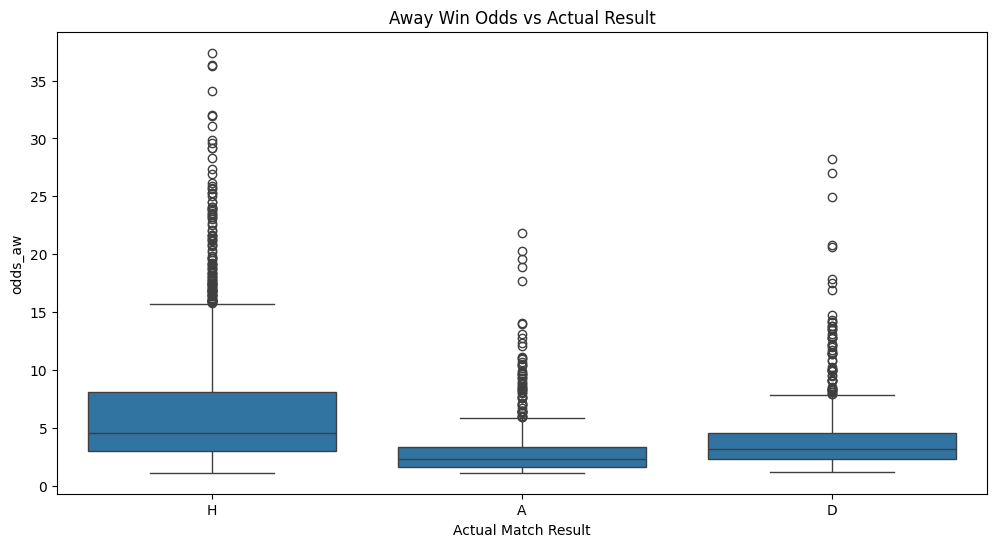

In [52]:
# Recreate FTR
db['FTR'] = db.apply(lambda row: 'H' if row['FTHG'] > row['FTAG'] else 'A' if row['FTAG'] > row['FTHG'] else 'D', axis=1)

# Map to numeric for plotting
ftr_map = {'H': 0, 'D': 1, 'A': 2}
db['FTR_numeric'] = db['FTR'].map(ftr_map)

# Plot boxplots
plt.figure(figsize=(12, 6))

sns.boxplot(x='FTR', y='odds_hw', data=db)
plt.title('Home Win Odds vs Actual Result')
plt.ylabel('odds_hw')
plt.xlabel('Actual Match Result')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='FTR', y='odds_d', data=db)
plt.title('Draw Odds vs Actual Result')
plt.ylabel('odds_d')
plt.xlabel('Actual Match Result')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='FTR', y='odds_aw', data=db)
plt.title('Away Win Odds vs Actual Result')
plt.ylabel('odds_aw')
plt.xlabel('Actual Match Result')
plt.show()


In [53]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,Referee,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away,avg_home_yellow_L5,avg_away_yellow_L5,avg_home_red_L5,avg_away_red_L5,h2h_avg_home_goals_last_5,h2h_avg_away_goals_last_5,TotalGoals,FTR,FTR_numeric
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,S Hooper,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14,4.15,4.65,1.0,2.4,0.0,0.2,1.0,1.25,2,D,1
2686,West Ham,Manchester City,1,3,M Oliver,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52,3.70,1.75,0.8,0.8,0.0,0.0,0.8,2.6,4,A,2
2687,Chelsea,Crystal Palace,1,1,J Gillett,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80,2.65,3.95,1.0,2.4,0.0,0.2,1.8,0.6,2,D,1
2688,Newcastle United,Tottenham,2,1,R Jones,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54,3.20,4.35,1.0,2.0,0.2,0.0,2.8,2.2,3,H,0
2689,Manchester United,Liverpool,0,3,A Taylor,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66,3.05,4.30,1.2,1.4,0.0,0.0,0.8,2.8,3,A,2


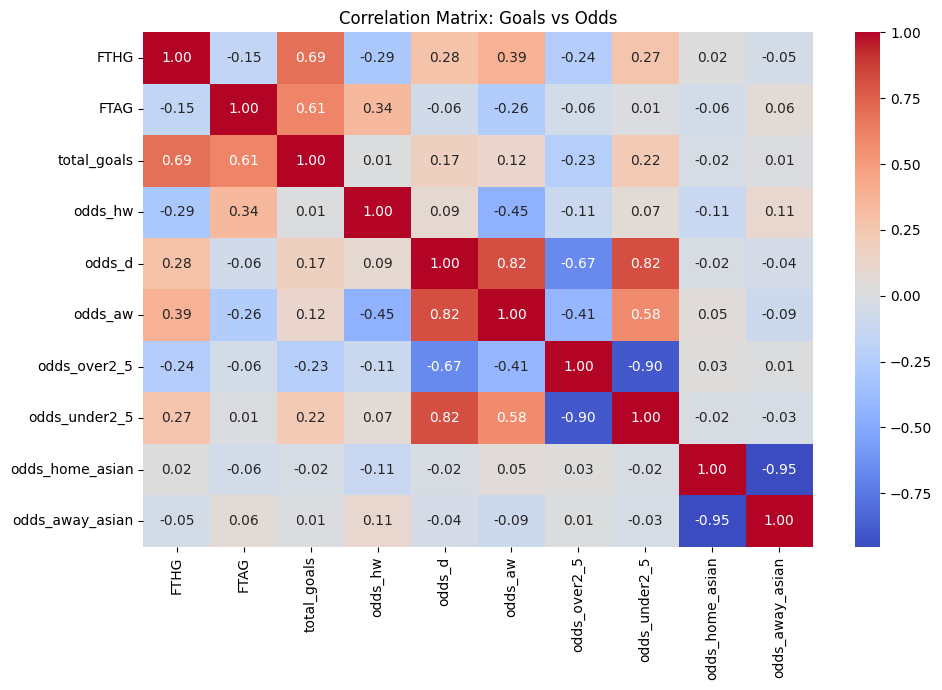

In [54]:

# Make sure total_goals exists
db['total_goals'] = db['FTHG'] + db['FTAG']

# Select relevant columns
corr_cols = [
    'FTHG', 'FTAG', 'total_goals',
    'odds_hw', 'odds_d', 'odds_aw',
    'odds_over2_5', 'odds_under2_5',
    'odds_home_asian', 'odds_away_asian'
]

# Compute correlation matrix
corr_matrix = db[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Goals vs Odds')
plt.tight_layout()
plt.show()

In [55]:
db.drop(columns=[
    'FTR', 'TotalGoals', 'FTR_numeric'
], inplace=True)

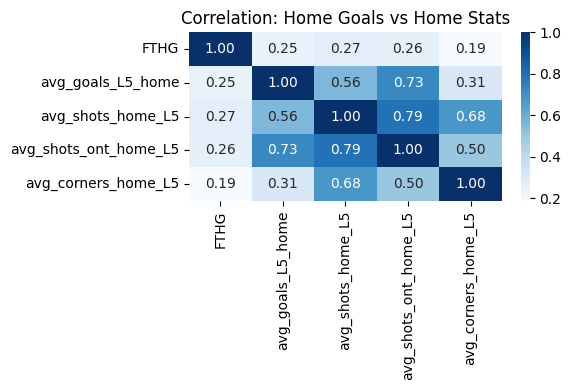

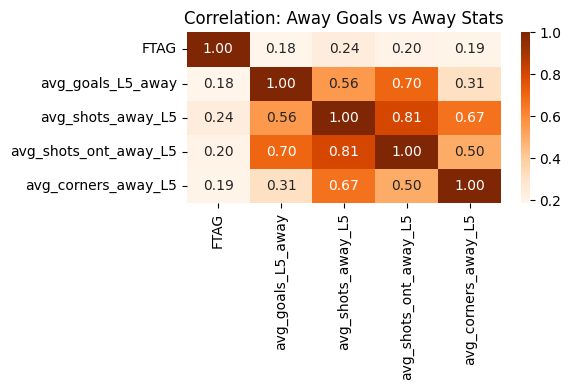

In [56]:
# 1. Correlation of FTHG with home team stats
home_corr_cols = [
    'FTHG',
    'avg_goals_L5_home',
    'avg_shots_home_L5',
    'avg_shots_ont_home_L5',
    'avg_corners_home_L5'
]

home_corr = db[home_corr_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(home_corr, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation: Home Goals vs Home Stats')
plt.tight_layout()
plt.show()


# 2. Correlation of FTAG with away team stats
away_corr_cols = [
    'FTAG',
    'avg_goals_L5_away',
    'avg_shots_away_L5',
    'avg_shots_ont_away_L5',
    'avg_corners_away_L5'
]

away_corr = db[away_corr_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(away_corr, annot=True, cmap='Oranges', fmt=".2f")
plt.title('Correlation: Away Goals vs Away Stats')
plt.tight_layout()
plt.show()

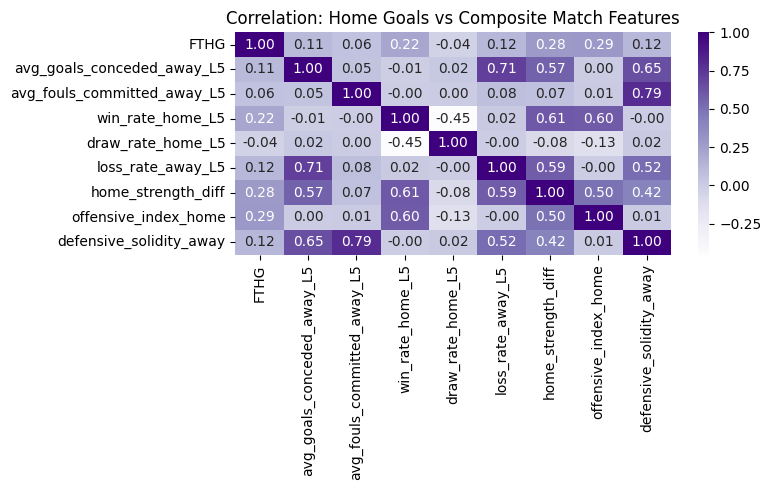

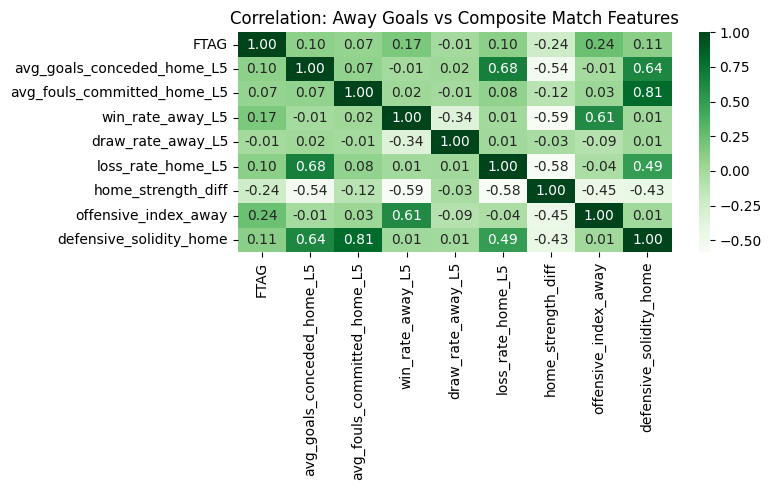

In [57]:

# 1. FTHG correlations
fthg_corr_cols = [
    'FTHG',
    'avg_goals_conceded_away_L5',
    'avg_fouls_committed_away_L5',
    'win_rate_home_L5',
    'draw_rate_home_L5',
    'loss_rate_away_L5',
    'home_strength_diff',
    'offensive_index_home',
    'defensive_solidity_away'
]

fthg_corr = db[fthg_corr_cols].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(fthg_corr, annot=True, cmap='Purples', fmt=".2f")
plt.title('Correlation: Home Goals vs Composite Match Features')
plt.tight_layout()
plt.show()


# 2. FTAG correlations
ftag_corr_cols = [
    'FTAG',
    'avg_goals_conceded_home_L5',
    'avg_fouls_committed_home_L5',
    'win_rate_away_L5',
    'draw_rate_away_L5',
    'loss_rate_home_L5',
    'home_strength_diff',
    'offensive_index_away',
    'defensive_solidity_home'
]

ftag_corr = db[ftag_corr_cols].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(ftag_corr, annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation: Away Goals vs Composite Match Features')
plt.tight_layout()
plt.show()

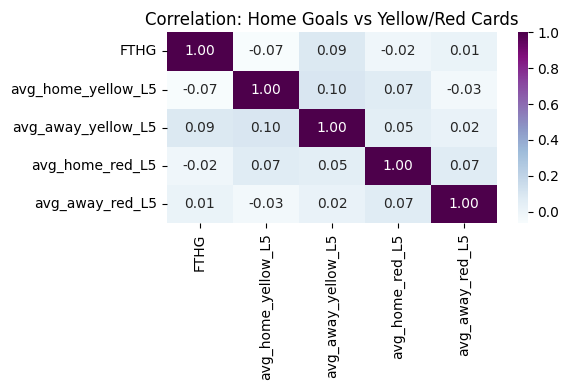

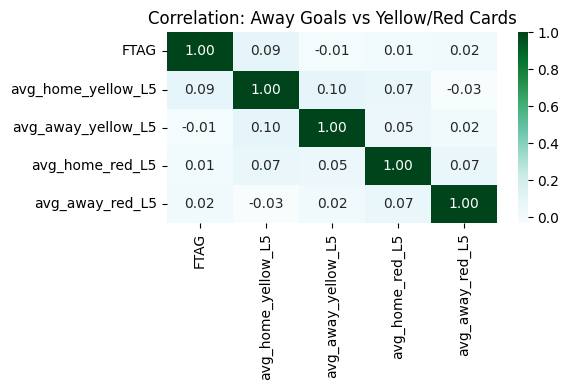

In [58]:

# 1. FTHG vs card features
fthg_card_cols = [
    'FTHG',
    'avg_home_yellow_L5',
    'avg_away_yellow_L5',
    'avg_home_red_L5',
    'avg_away_red_L5'
]

fthg_card_corr = db[fthg_card_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(fthg_card_corr, annot=True, cmap='BuPu', fmt=".2f")
plt.title('Correlation: Home Goals vs Yellow/Red Cards')
plt.tight_layout()
plt.show()


# 2. FTAG vs card features
ftag_card_cols = [
    'FTAG',
    'avg_home_yellow_L5',
    'avg_away_yellow_L5',
    'avg_home_red_L5',
    'avg_away_red_L5'
]

ftag_card_corr = db[ftag_card_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(ftag_card_corr, annot=True, cmap='BuGn', fmt=".2f")
plt.title('Correlation: Away Goals vs Yellow/Red Cards')
plt.tight_layout()
plt.show()

Since yellow and red cards have very weak correlation with our target variables and appear to contribute little predictive power. Therefore, we will drop them to reduce feature noise and dimensionality.

In [59]:
db.drop(columns=[
    'total_goals', 'avg_home_yellow_L5', 'avg_away_yellow_L5', 'avg_home_red_L5', 'avg_away_red_L5'
], inplace=True)

In [60]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,Referee,Time,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away,h2h_avg_home_goals_last_5,h2h_avg_away_goals_last_5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,S Hooper,15:00,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14,4.15,4.65,1.0,1.25
2686,West Ham,Manchester City,1,3,M Oliver,17:30,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52,3.70,1.75,0.8,2.6
2687,Chelsea,Crystal Palace,1,1,J Gillett,13:30,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80,2.65,3.95,1.8,0.6
2688,Newcastle United,Tottenham,2,1,R Jones,13:30,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54,3.20,4.35,2.8,2.2
2689,Manchester United,Liverpool,0,3,A Taylor,16:00,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66,3.05,4.30,0.8,2.8


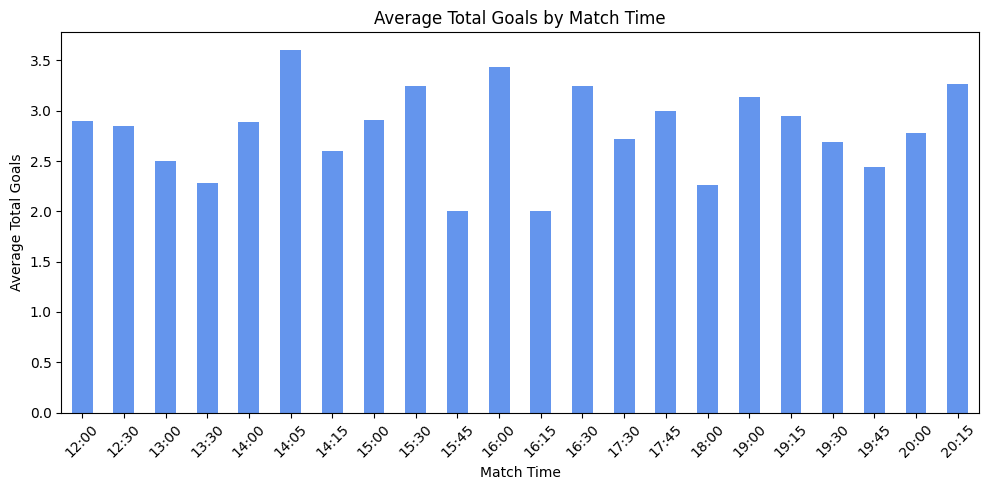

In [61]:

# Ensure total_goals column exists
db['total_goals'] = db['FTHG'] + db['FTAG']

# Drop rows with missing time
time_goals = db.dropna(subset=['Time'])

# Compute average total goals per time
avg_goals_by_time = time_goals.groupby('Time')['total_goals'].mean().sort_index()

# Plot
plt.figure(figsize=(10, 5))
avg_goals_by_time.plot(kind='bar', color='cornflowerblue')
plt.title('Average Total Goals by Match Time')
plt.ylabel('Average Total Goals')
plt.xlabel('Match Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Although we initially considered including the Time feature to explore whether kick-off time had any relationship with match outcomes (such as total goals), our analysis showed that its predictive power was negligible. The correlation between Time (converted into minutes) and total_goals was extremely low, and while the bar plot of average total goals by match time revealed some variation, it did not display any clear or consistent pattern strong enough to inform or improve predictions.

In [62]:
db.drop(columns=[
     'total_goals', 'Time'
], inplace=True)

In [63]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,Referee,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away,h2h_avg_home_goals_last_5,h2h_avg_away_goals_last_5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,S Hooper,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14,4.15,4.65,1.0,1.25
2686,West Ham,Manchester City,1,3,M Oliver,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52,3.70,1.75,0.8,2.6
2687,Chelsea,Crystal Palace,1,1,J Gillett,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80,2.65,3.95,1.8,0.6
2688,Newcastle United,Tottenham,2,1,R Jones,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54,3.20,4.35,2.8,2.2
2689,Manchester United,Liverpool,0,3,A Taylor,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66,3.05,4.30,0.8,2.8


In [64]:
db.isnull().sum()

HomeTeam                         0
AwayTeam                         0
FTHG                             0
FTAG                             0
Referee                          0
odds_hw                          0
odds_d                           0
odds_aw                          0
odds_over2_5                     0
odds_under2_5                    0
odds_home_asian                760
odds_away_asian                760
avg_goals_L5_home               31
avg_goals_L5_away               31
avg_shots_home_L5               31
avg_shots_away_L5               31
avg_shots_ont_home_L5           31
avg_shots_ont_away_L5           31
avg_corners_home_L5             31
avg_corners_away_L5             31
avg_goals_conceded_home_L5      31
avg_goals_conceded_away_L5      31
avg_fouls_committed_home_L5     31
avg_fouls_committed_away_L5     31
win_rate_home_L5                31
win_rate_away_L5                31
draw_rate_home_L5               31
draw_rate_away_L5               31
loss_rate_home_L5   

Handling missing values

In [65]:
# Fill Asian odds (odds_home_asian, odds_away_asian) with overall column mean
db['odds_home_asian'].fillna(db['odds_home_asian'].mean(), inplace=True)
db['odds_away_asian'].fillna(db['odds_away_asian'].mean(), inplace=True)

# Home team features to fill with home team averages
home_l5_cols = [
    'avg_goals_L5_home', 'avg_shots_home_L5', 'avg_shots_ont_home_L5',
    'avg_corners_home_L5', 'avg_goals_conceded_home_L5',
    'avg_fouls_committed_home_L5', 'win_rate_home_L5', 'draw_rate_home_L5',
    'loss_rate_home_L5', 'offensive_index_home', 'defensive_solidity_home'
]

# Away team features to fill with away team averages
away_l5_cols = [
    'avg_goals_L5_away', 'avg_shots_away_L5', 'avg_shots_ont_away_L5',
    'avg_corners_away_L5', 'avg_goals_conceded_away_L5',
    'avg_fouls_committed_away_L5', 'win_rate_away_L5', 'draw_rate_away_L5',
    'loss_rate_away_L5', 'offensive_index_away', 'defensive_solidity_away'
]

# Fill missing home values with HomeTeam-wise means
for col in home_l5_cols:
    db[col] = db.groupby('HomeTeam')[col].transform(lambda x: x.fillna(x.mean()))

# Fill missing away values with AwayTeam-wise means
for col in away_l5_cols:
    db[col] = db.groupby('AwayTeam')[col].transform(lambda x: x.fillna(x.mean()))

# Fill h2h columns with the global mean as fallback (very sparse data)
db['h2h_avg_home_goals_last_5'].fillna(db['h2h_avg_home_goals_last_5'].mean(), inplace=True)
db['h2h_avg_away_goals_last_5'].fillna(db['h2h_avg_away_goals_last_5'].mean(), inplace=True)


In [66]:
db['home_strength_diff'] = (db['avg_goals_L5_home'] - db['avg_goals_conceded_home_L5']) - (db['avg_goals_L5_away'] - db['avg_goals_conceded_away_L5'])


In [67]:
db.isnull().sum()

HomeTeam                       0
AwayTeam                       0
FTHG                           0
FTAG                           0
Referee                        0
odds_hw                        0
odds_d                         0
odds_aw                        0
odds_over2_5                   0
odds_under2_5                  0
odds_home_asian                0
odds_away_asian                0
avg_goals_L5_home              0
avg_goals_L5_away              1
avg_shots_home_L5              0
avg_shots_away_L5              1
avg_shots_ont_home_L5          0
avg_shots_ont_away_L5          1
avg_corners_home_L5            0
avg_corners_away_L5            1
avg_goals_conceded_home_L5     0
avg_goals_conceded_away_L5     1
avg_fouls_committed_home_L5    0
avg_fouls_committed_away_L5    1
win_rate_home_L5               0
win_rate_away_L5               1
draw_rate_home_L5              0
draw_rate_away_L5              1
loss_rate_home_L5              0
loss_rate_away_L5              1
home_stren

In [68]:
db.fillna(db.mean(numeric_only=True), inplace=True)


In [69]:
db.isnull().sum()

HomeTeam                       0
AwayTeam                       0
FTHG                           0
FTAG                           0
Referee                        0
odds_hw                        0
odds_d                         0
odds_aw                        0
odds_over2_5                   0
odds_under2_5                  0
odds_home_asian                0
odds_away_asian                0
avg_goals_L5_home              0
avg_goals_L5_away              0
avg_shots_home_L5              0
avg_shots_away_L5              0
avg_shots_ont_home_L5          0
avg_shots_ont_away_L5          0
avg_corners_home_L5            0
avg_corners_away_L5            0
avg_goals_conceded_home_L5     0
avg_goals_conceded_away_L5     0
avg_fouls_committed_home_L5    0
avg_fouls_committed_away_L5    0
win_rate_home_L5               0
win_rate_away_L5               0
draw_rate_home_L5              0
draw_rate_away_L5              0
loss_rate_home_L5              0
loss_rate_away_L5              0
home_stren

In [70]:
db.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,Referee,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away,h2h_avg_home_goals_last_5,h2h_avg_away_goals_last_5
2685,Nottingham Forest,Wolverhampton Wanderers,1,1,S Hooper,2.024375,3.643125,3.720000,1.879,2.030,2.036667,1.905000,1.6,0.8,16.4,6.8,5.4,2.6,4.8,1.8,1.8,2.4,12.2,12.8,0.2,0.0,0.4,0.4,0.4,0.6,1.4,7.18,3.14,4.15,4.65,1.0,1.25
2686,West Ham,Manchester City,1,3,M Oliver,7.575000,5.280625,1.396875,1.518,2.690,1.936667,1.991667,1.4,2.8,15.0,12.0,5.4,6.0,6.8,4.6,1.6,0.0,10.8,7.0,0.2,1.0,0.4,0.0,0.4,0.0,-3.0,6.68,6.52,3.70,1.75,0.8,2.60
2687,Chelsea,Crystal Palace,1,1,J Gillett,1.643125,4.344375,5.000000,1.545,2.599,1.950000,1.985000,3.0,1.2,16.2,10.4,7.6,4.0,5.2,4.4,0.6,1.0,9.2,13.2,0.8,0.4,0.0,0.2,0.2,0.4,2.2,8.34,4.80,2.65,3.95,1.8,0.60
2688,Newcastle United,Tottenham,2,1,R Jones,2.500000,3.950000,2.596250,1.405,3.118,1.928333,2.008333,2.4,1.2,15.4,14.8,5.2,5.4,7.6,6.8,0.6,2.2,11.2,12.2,0.6,0.2,0.4,0.2,0.0,0.6,2.8,7.14,6.54,3.20,4.35,2.8,2.20
2689,Manchester United,Liverpool,0,3,A Taylor,3.720000,4.125625,1.901875,1.462,2.871,2.005000,1.933333,1.8,2.0,19.4,19.4,7.6,6.8,7.0,7.8,1.2,1.6,9.4,13.4,0.6,0.4,0.2,0.4,0.2,0.2,0.2,8.82,8.66,3.05,4.30,0.8,2.80


In [71]:
# There is one referee that has one game with a spare space
db['Referee'] = db['Referee'].str.strip()


In [72]:
# Split
X = db.drop(columns=['FTHG', 'FTAG'])
y = db[['FTHG', 'FTAG']]

# Indices
train_end = -4
val_end = -2

# Create splits
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]


### BASELINE:  
This is a mean-based baseline: predict the average number of home and away goals from the training set for every match.

In [73]:
# Compute average goals in training set
baseline_fthg = y_train['FTHG'].mean()
baseline_ftag = y_train['FTAG'].mean()

# Predict these for every match in the validation set
baseline_pred_fthg = [baseline_fthg] * len(y_val)
baseline_pred_ftag = [baseline_ftag] * len(y_val)

# Compute MSE for each target
baseline_mse_fthg = mean_squared_error(y_val['FTHG'], baseline_pred_fthg)
baseline_mse_ftag = mean_squared_error(y_val['FTAG'], baseline_pred_ftag)

print(f"Baseline MSE (FTHG): {baseline_mse_fthg:.3f}")
print(f"Baseline MSE (FTAG): {baseline_mse_ftag:.3f}")


Baseline MSE (FTHG): 0.311
Baseline MSE (FTAG): 1.519


### ENCODING

In [74]:
# Create team ID mapping before encoding
teams = pd.unique(db[['HomeTeam', 'AwayTeam']].values.ravel())
team_to_id = {team: idx for idx, team in enumerate(teams)}

# Map into ID columns
X_train['HomeTeam_ID'] = X_train['HomeTeam'].map(team_to_id)
X_train['AwayTeam_ID'] = X_train['AwayTeam'].map(team_to_id)

X_val['HomeTeam_ID'] = X_val['HomeTeam'].map(team_to_id)
X_val['AwayTeam_ID'] = X_val['AwayTeam'].map(team_to_id)

X_test['HomeTeam_ID'] = X_test['HomeTeam'].map(team_to_id)
X_test['AwayTeam_ID'] = X_test['AwayTeam'].map(team_to_id)


In [75]:
# Sategorical columns
categorical_cols = ['HomeTeam', 'AwayTeam', 'Referee']

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on training data only
encoded_train = encoder.fit_transform(X_train[categorical_cols])

# Apply to validation and test sets
encoded_val = encoder.transform(X_val[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

# Get encoded column names
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

# Convert to DataFrames
import pandas as pd

encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_col_names, index=X_train.index)
encoded_val_df = pd.DataFrame(encoded_val, columns=encoded_col_names, index=X_val.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_col_names, index=X_test.index)

# Drop original categorical columns and join encoded ones
X_train = X_train.drop(columns=categorical_cols).join(encoded_train_df)
X_val = X_val.drop(columns=categorical_cols).join(encoded_val_df)
X_test = X_test.drop(columns=categorical_cols).join(encoded_test_df)

In [76]:
X_train.head()

,odds_hw,odds_d,odds_aw,odds_over2_5,odds_under2_5,odds_home_asian,odds_away_asian,avg_goals_L5_home,avg_goals_L5_away,avg_shots_home_L5,avg_shots_away_L5,avg_shots_ont_home_L5,avg_shots_ont_away_L5,avg_corners_home_L5,avg_corners_away_L5,avg_goals_conceded_home_L5,avg_goals_conceded_away_L5,avg_fouls_committed_home_L5,avg_fouls_committed_away_L5,win_rate_home_L5,win_rate_away_L5,draw_rate_home_L5,draw_rate_away_L5,loss_rate_home_L5,loss_rate_away_L5,home_strength_diff,offensive_index_home,offensive_index_away,defensive_solidity_home,defensive_solidity_away,h2h_avg_home_goals_last_5,h2h_avg_away_goals_last_5,HomeTeam_ID,AwayTeam_ID,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Manchester City,HomeTeam_Manchester United,HomeTeam_Newcastle United,HomeTeam_Norwich,HomeTeam_Nottingham Forest,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Bromwich Albion,HomeTeam_West Ham,HomeTeam_Wolverhampton Wanderers,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Bournemouth,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Manchester City,AwayTeam_Manchester United,AwayTeam_Newcastle United,AwayTeam_Norwich,AwayTeam_Nottingham Forest,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Bromwich Albion,AwayTeam_West Ham,AwayTeam_Wolverhampton Wanderers,Referee_A Madley,Referee_A Marriner,Referee_A Moss,Referee_A Taylor,Referee_C Kavanagh,Referee_C Pawson,Referee_D Bond,Referee_D Coote,Referee_D England,Referee_G Scott,Referee_J Brooks,Referee_J Gillett,Referee_J Moss,Referee_J Smith,Referee_K Friend,Referee_L Mason,Referee_L Probert,Referee_L Smith,Referee_M Atkinson,Referee_M Dean,Referee_M Donohue,Referee_M Jones,Referee_M Oliver,Referee_M Salisbury,Referee_N Swarbrick,Referee_O Langford,Referee_P Bankes,Referee_P Tierney,Referee_R East,Referee_R Jones,Referee_R Madley,Referee_R Welch,Referee_S Allison,Referee_S Attwell,Referee_S Barrott,Referee_S Hooper,Referee_S Scott,Referee_S Singh,Referee_T Bramall,Referee_T Harrington,Referee_T Robinson
0,1.50250,4.49750,6.60625,1.630,2.375,1.956823,1.95889,2.209328,1.593275,16.049627,11.637281,5.884204,4.349269,6.750498,4.901462,1.061567,1.660380,10.312935,10.085819,0.671642,0.333333,0.164179,0.228363,0.164179,0.438304,1.214866,7.463881,5.433275,3.191107,3.518311,1.352646,1.423075,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.33750,5.38125,1.32125,1.665,2.335,1.956823,1.95889,1.290852,2.163308,14.054010,16.633831,4.396742,6.153234,5.984461,6.903483,1.296992,0.794652,10.960526,8.907960,0.340351,0.708955,0.346241,0.134328,0.313409,0.156716,-1.374797,6.051566,7.701443,3.553540,2.697077,1.352646,1.423075,2,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [77]:
pd.set_option('display.max_columns', None)
print(X_train.columns.tolist())

['odds_hw', 'odds_d', 'odds_aw', 'odds_over2_5', 'odds_under2_5', 'odds_home_asian', 'odds_away_asian', 'avg_goals_L5_home', 'avg_goals_L5_away', 'avg_shots_home_L5', 'avg_shots_away_L5', 'avg_shots_ont_home_L5', 'avg_shots_ont_away_L5', 'avg_corners_home_L5', 'avg_corners_away_L5', 'avg_goals_conceded_home_L5', 'avg_goals_conceded_away_L5', 'avg_fouls_committed_home_L5', 'avg_fouls_committed_away_L5', 'win_rate_home_L5', 'win_rate_away_L5', 'draw_rate_home_L5', 'draw_rate_away_L5', 'loss_rate_home_L5', 'loss_rate_away_L5', 'home_strength_diff', 'offensive_index_home', 'offensive_index_away', 'defensive_solidity_home', 'defensive_solidity_away', 'h2h_avg_home_goals_last_5', 'h2h_avg_away_goals_last_5', 'HomeTeam_ID', 'AwayTeam_ID', 'HomeTeam_Arsenal', 'HomeTeam_Aston Villa', 'HomeTeam_Bournemouth', 'HomeTeam_Brentford', 'HomeTeam_Brighton', 'HomeTeam_Burnley', 'HomeTeam_Cardiff', 'HomeTeam_Chelsea', 'HomeTeam_Crystal Palace', 'HomeTeam_Everton', 'HomeTeam_Fulham', 'HomeTeam_Huddersfiel

## MODEL EVALUATION